In [49]:
import os, sys
import dotenv

import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.append(os.environ.get('PATH_OPENSKY'))
from user_eval import get_df_posts 
from news_outlet_eval import get_news_feed, get_posts_from_nos

dotenv.load_dotenv('.env')    
PATH_DATA = os.environ.get('PATH_OPENSKY') + os.environ.get('PATH_REL_DATA')
PATH_USER_POSTS = PATH_DATA + 'user_posts/'

PATH_RESULTS = os.environ.get('PATH_OPENSKY') + 'results/'
PATH_USER_REPLIES_NEWS = PATH_RESULTS + 'agg_user_replies_news_2.csv'
PATH_USER_REPLIES_NEWS_POSTS = PATH_RESULTS + 'agg_user_replies_news_posts_2.csv'

PATH_FEED_POSTS = PATH_DATA + 'feed_posts/'

df = pd.read_csv(PATH_USER_REPLIES_NEWS_POSTS)

/tmp/ipykernel_1139276/3162021229.py:24: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PATH_USER_REPLIES_NEWS_POSTS)


In [50]:
df

,post_id,user_id,instance,date,text,langs,like_count,reply_count,repost_count,reply_to,replied_author,thread_root,thread_root_author,repost_from,reposted_author,quotes,quoted_author,labels,sent_label,sent_score
0,10657080,284413,bsky.social,2024-01-14 08:03:00,let’s hope his expands ten fold 💪💪,['eng'],0,0,0,10657081.0,15717.0,10657081.0,15717.0,NaN,NaN,NaN,NaN,NaN,2.0,0.945
1,10657084,284413,bsky.social,2024-01-12 22:12:00,"yes, we can do this! 💪",['eng'],3,0,0,5595208.0,2486.0,5595208.0,2486.0,NaN,NaN,NaN,NaN,NaN,2.0,0.956
2,10657085,284413,bsky.social,2024-01-11 14:19:00,"in other words, “as long as it takes” it refer...",['eng'],0,1,0,10657086.0,12030.0,10657086.0,12030.0,NaN,NaN,NaN,NaN,NaN,1.0,0.583
3,10657096,284413,bsky.social,2024-01-08 14:10:00,i’ll believe it when i see the weapons in Ukra...,['eng'],0,0,0,10657097.0,15717.0,10657097.0,15717.0,NaN,NaN,NaN,NaN,NaN,1.0,0.509
4,10657117,284413,bsky.social,2024-01-05 09:22:00,Expect the world to become way way worse. If a...,['eng'],1,0,0,5271912.0,15717.0,5271912.0,15717.0,NaN,NaN,NaN,NaN,NaN,0.0,0.890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36816,171050451,141248,bsky.social,2024-03-09 13:47:00,La preuve qu'ils sont antidémocratiques. \nPer...,"['eng', 'fra']",4,0,0,5550653.0,4890.0,5550653.0,4890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36817,105014318,92560,bsky.social,2024-03-08 01:59:00,What a complete abdication of good journalism ...,['eng'],0,0,0,698597.0,9.0,698597.0,9.0,NaN,NaN,NaN,NaN,NaN,0.0,0.790
36818,105014322,92560,bsky.social,2024-03-07 22:16:00,Trump and Biden are at par with age...exactly ...,['eng'],4,0,0,127576.0,379.0,127576.0,379.0,NaN,NaN,NaN,NaN,NaN,0.0,0.867
36819,105014501,92560,bsky.social,2024-01-05 08:08:00,Because doctors are literally refusing to pres...,['eng'],1,0,0,145919.0,379.0,145919.0,379.0,NaN,NaN,NaN,NaN,NaN,0.0,0.882


In [51]:
bm_first_depth = (df.reply_to == df.thread_root)
df = df[bm_first_depth]
df.dropna(subset=['sent_label'], inplace=True)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
# Set 'date_column' as the index
df.set_index('date', inplace=True)
df

# Sort the DataFrame by the index to ensure it's monotonic
df.sort_index(inplace=True)

sent_label_mapping = { 0: 'negative', 1: 'neutral', 2: 'positive'}
df.loc[:, 'sent_label'] = df.sent_label.map(sent_label_mapping)
df

/tmp/ipykernel_1139276/4077494997.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['sent_label'], inplace=True)
/tmp/ipykernel_1139276/4077494997.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'], errors='coerce')
/tmp/ipykernel_1139276/4077494997.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_index(inpla

,post_id,user_id,instance,text,langs,like_count,reply_count,repost_count,reply_to,replied_author,thread_root,thread_root_author,repost_from,reposted_author,quotes,quoted_author,labels,sent_label,sent_score
date,,,,,,,,,,,,,,,,,,,
2023-06-28 21:18:00,168434516,1372567,bsky.social,i've seen hotter areas.,['eng'],0,0,0,19782403.0,379.0,19782403.0,379.0,NaN,NaN,NaN,NaN,NaN,neutral,0.761
2023-06-29 15:38:00,17266419,153449,bsky.social,This Supreme Court is a joke.,['eng'],0,0,0,6725329.0,379.0,6725329.0,379.0,NaN,NaN,NaN,NaN,NaN,negative,0.938
2023-06-29 18:07:00,107515831,63826,com,"Join us on Sunday, July 9, at 3:00 p.m. for “C...",['eng'],1,0,1,107515830.0,63826.0,107515830.0,63826.0,NaN,NaN,NaN,NaN,NaN,neutral,0.499
2023-06-29 19:47:00,207928205,31264,bsky.social,welcome,['eng'],0,0,0,20551625.0,5221.0,20551625.0,5221.0,NaN,NaN,NaN,NaN,NaN,positive,0.751
2023-07-02 14:47:00,48526676,281025,bsky.social,"Even knowing this is The Onion, I can't tell i...",['eng'],1,0,0,176024.0,114.0,176024.0,114.0,NaN,NaN,NaN,NaN,NaN,negative,0.748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-18 23:44:00,177355488,357175,bsky.social,"They knew it was deadly long ago!\nIn 1900, a ...",['eng'],2,1,2,10705540.0,9.0,10705540.0,9.0,77830213.0,2089172.0,NaN,NaN,NaN,negative,0.834
2024-03-18 23:44:00,77830213,2089172,bsky.social,"They knew it was deadly long ago!\nIn 1900, a ...",['eng'],2,1,2,10705540.0,9.0,10705540.0,9.0,NaN,NaN,NaN,NaN,NaN,negative,0.834
2024-03-18 23:45:00,70495008,152971,bsky.social,Gotta catch ‘em all!,['eng'],2,1,0,3753243.0,379.0,3753243.0,379.0,NaN,NaN,NaN,NaN,NaN,neutral,0.549


In [52]:
df.reply_to.nunique()

5678

In [53]:
replies_per_post = df.groupby('reply_to').agg({'sent_label': 'count'}).rename(columns={'sent_label' : 'nr_of_replies'})#.reset_index()
replies_per_post

,nr_of_replies
reply_to,
517.0,5
1619.0,44
1795.0,2
2233.0,5
16974.0,20
...,...
224902213.0,1
224902317.0,1
224902333.0,1


In [54]:
labels_per_post = df.groupby(['reply_to', 'sent_label']).agg({'sent_label': 'count'}).rename(columns={'sent_label': 'count'})#.pivot(index='reply_to', columns='sent_label', values='count').fillna(0)
labels_per_post

count
reply_to    sent_label       
517.0       negative        5
1619.0      negative       37
            neutral         3
            positive        4
1795.0      negative        1
...                       ...
224902213.0 neutral         1
224902317.0 negative        1
224902333.0 neutral         1
224902374.0 negative        1
227102711.0 positive        1

[7989 rows x 1 columns]

In [56]:
proportions_per_post = labels_per_post.join(replies_per_post)
proportions_per_post['proportion'] = proportions_per_post['count'] / proportions_per_post['nr_of_replies']
proportions_per_post

count  nr_of_replies  proportion
reply_to    sent_label                                  
517.0       negative        5              5    1.000000
1619.0      negative       37             44    0.840909
            neutral         3             44    0.068182
            positive        4             44    0.090909
1795.0      negative        1              2    0.500000
...                       ...            ...         ...
224902213.0 neutral         1              1    1.000000
224902317.0 negative        1              1    1.000000
224902333.0 neutral         1              1    1.000000
224902374.0 negative        1              1    1.000000
227102711.0 positive        1              1    1.000000

[7989 rows x 3 columns]

In [61]:
(proportions_per_post.nr_of_replies > 1).sum()

np.int64(5004)

In [64]:
proportions_per_post = proportions_per_post[proportions_per_post.nr_of_replies > 1]
proportions_per_post

count  nr_of_replies  proportion
reply_to    sent_label                                  
517.0       negative        5              5    1.000000
1619.0      negative       37             44    0.840909
            neutral         3             44    0.068182
            positive        4             44    0.090909
1795.0      negative        1              2    0.500000
...                       ...            ...         ...
148092095.0 neutral         2              2    1.000000
148094325.0 neutral         1              2    0.500000
            positive        1              2    0.500000
181654838.0 neutral         1              2    0.500000
            positive        1              2    0.500000

[5004 rows x 3 columns]

<Axes: >

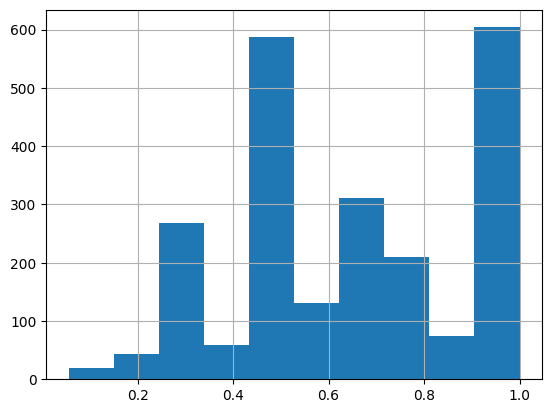

In [65]:
proportions_per_post.reset_index(inplace=True)
proportions_per_post.loc[proportions_per_post.sent_label == 'negative', 'proportion'].hist()